In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WideBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.0):
        super(WideBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class WideResNet(nn.Module):
    def __init__(self, block, widen_factor, num_blocks, num_classes=100, dropout_rate=0.0):
        super(WideResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16 * widen_factor, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self.make_layer(block, 32 * widen_factor, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self.make_layer(block, 64 * widen_factor, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * widen_factor, num_classes)

    def make_layer(self, block, out_channels, blocks, stride, dropout_rate):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, dropout_rate))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out=torch.flatten(out,1)
        out=self.fc(out)
        return out

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
from basic_tools import *

In [20]:
#一些参数的设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate=0.01
momentum=0.9
weight_decay=0.0001
batch_size=128
epochs=100
data_path='./data'
model_name='WideBasicResNet_'+'epoch='+str(epochs)
print(device)
model=WideResNet(WideBasicBlock,8,[2,2,2]).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

cuda:0


In [21]:
#数据集的加载
trainloader,testloader=get_data_loaders(train_batch_size=batch_size,test_batch_size=batch_size,data_path=data_path)

Files already downloaded and verified
Files already downloaded and verified


epoch:0,train_loss:3.5921,train_acc:15.1260,train_top5_acc:39.1860,test_loss:3.2432,test_acc:21.1100,test_top5_acc:50.4500
epoch:1,train_loss:2.7434,train_acc:29.3980,train_top5_acc:61.7060,test_loss:2.7408,test_acc:30.7900,test_top5_acc:62.9300
epoch:2,train_loss:2.2765,train_acc:39.3740,train_top5_acc:72.1520,test_loss:2.3845,test_acc:37.2600,test_top5_acc:70.5300
epoch:3,train_loss:1.9658,train_acc:46.6160,train_top5_acc:78.4000,test_loss:2.0800,test_acc:44.7200,test_top5_acc:77.0500
epoch:4,train_loss:1.7473,train_acc:51.3180,train_top5_acc:82.3180,test_loss:2.1548,test_acc:44.9100,test_top5_acc:76.3100
epoch:5,train_loss:1.5760,train_acc:55.6380,train_top5_acc:85.4560,test_loss:2.1112,test_acc:47.7900,test_top5_acc:77.9200
epoch:6,train_loss:1.4341,train_acc:59.1080,train_top5_acc:87.6000,test_loss:1.7573,test_acc:53.7200,test_top5_acc:82.9500
epoch:7,train_loss:1.3137,train_acc:62.1960,train_top5_acc:89.2240,test_loss:1.7615,test_acc:53.1300,test_top5_acc:83.3100
epoch:8,train_lo

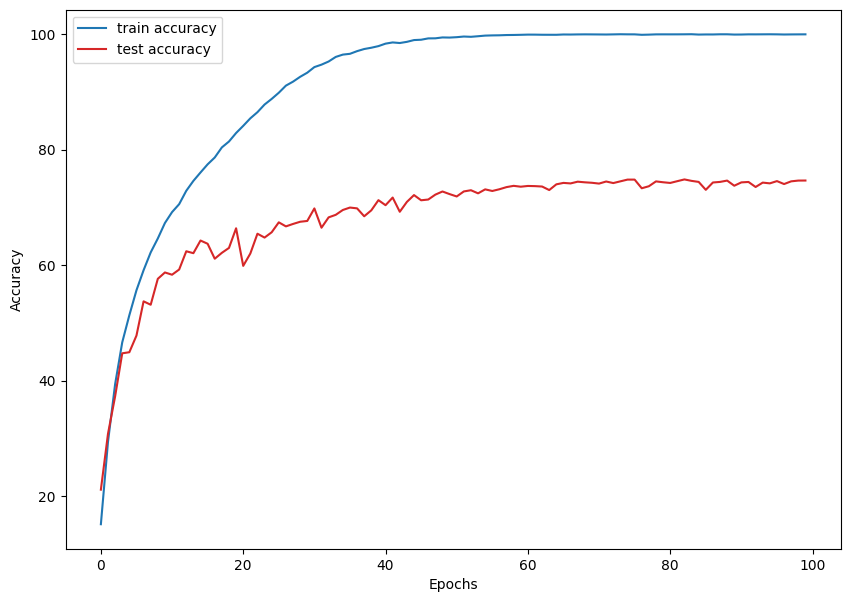

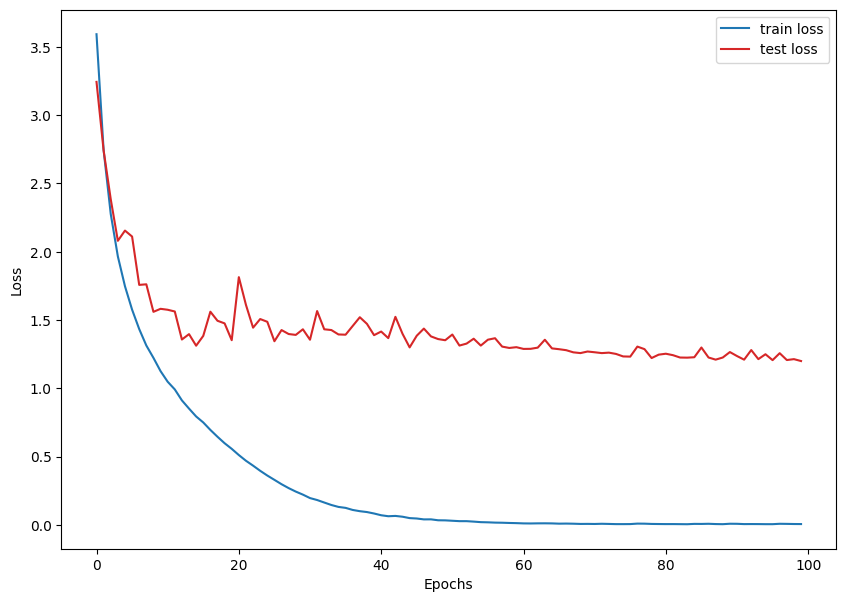

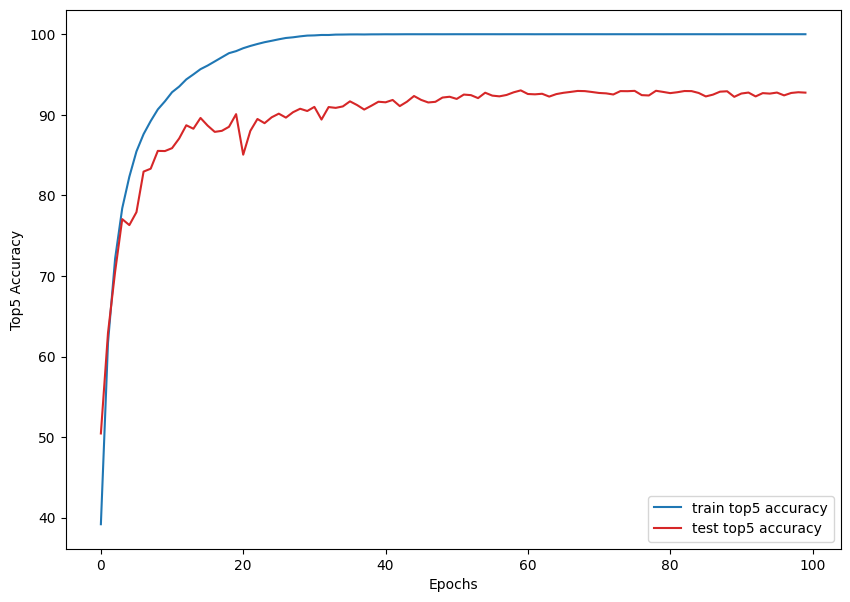

In [22]:
#训练之
train_lossa, test_lossa = [], []
train_acca, test_acca = [], []
train_top5_acca, test_top5_acca = [], []
for epoch in range(epochs):
    train_loss,train_acc,train_top5_acc=train(model,trainloader,criterion,optimizer,device)
    test_loss,test_acc,test_top5_acc=test(model,testloader,criterion,device)
    print('epoch:{},train_loss:{:.4f},train_acc:{:.4f},train_top5_acc:{:.4f},test_loss:{:.4f},test_acc:{:.4f},test_top5_acc:{:.4f}'.format(epoch,train_loss,train_acc,train_top5_acc,test_loss,test_acc,test_top5_acc))
    #torch.save(model.state_dict(), model_name+'.pth')
    train_lossa.append(train_loss)
    test_lossa.append(test_loss)
    train_acca.append(train_acc)
    test_acca.append(test_acc)
    train_top5_acca.append(train_top5_acc)
    test_top5_acca.append(test_top5_acc)

#画图
save_plots(train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,model_name)
save_log(model_name,train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca)
save_model_info(model_name,model,train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,learning_rate,epochs,momentum,weight_decay)

In [23]:
#固定模型
import os
modelpath='./models/'
if not os.path.exists(modelpath):
    os.makedirs(modelpath)
torch.save(model.state_dict(),modelpath+model_name+'.pth')